# Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn
# Курсовой проект: Exploratory Data Analysis

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

 ## 1 Чтение данных

In [169]:
train_data = pd.read_csv("train.csv")
X = train_data.drop("Price", axis = 1)
y = train_data["Price"]

## 2 Анализ признаков

### 2.1 Проверка количественных признаков на выбросы

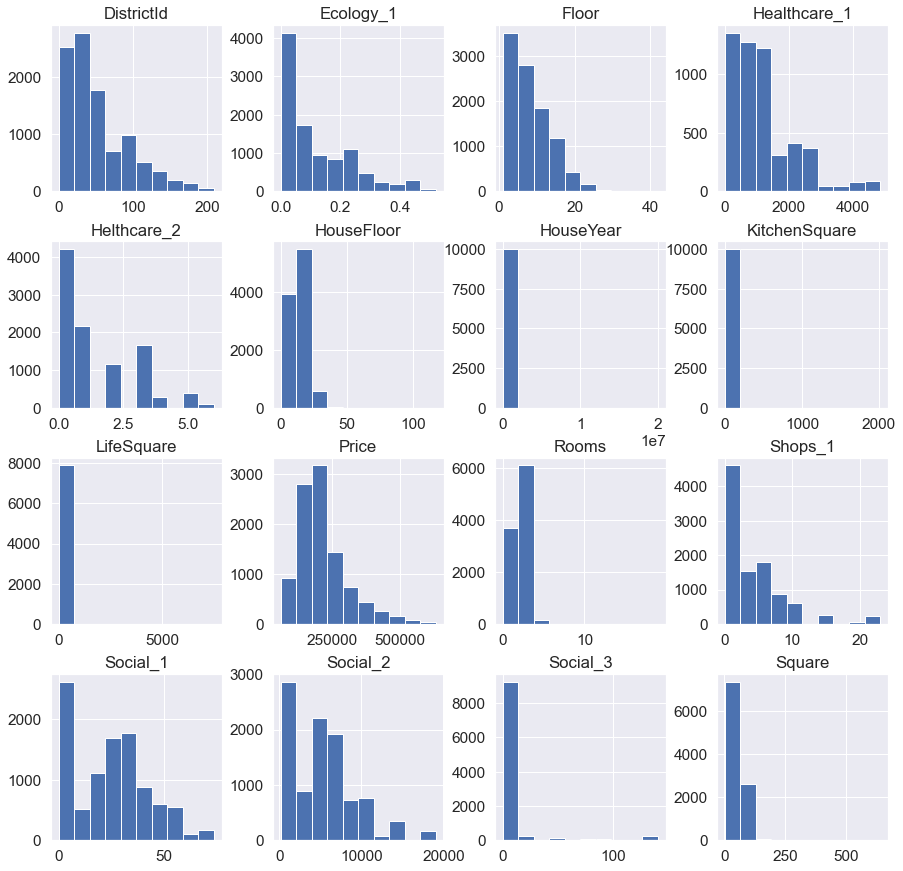

In [170]:
numeric_features = train_data.select_dtypes(exclude='object')
numeric_features = pd.DataFrame(numeric_features)
numeric_features.drop("Id", axis=1, inplace=True)
numeric_features.hist(figsize=(15, 15), bins = 10);

### 2.2 Анализ признаков с выбросами

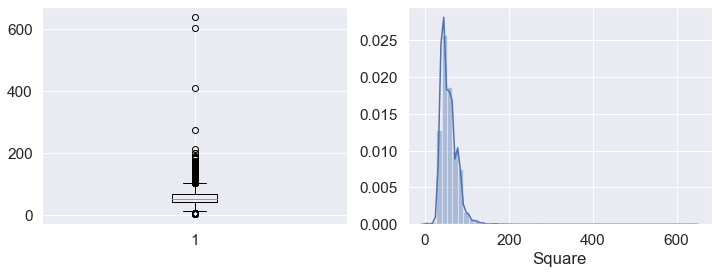

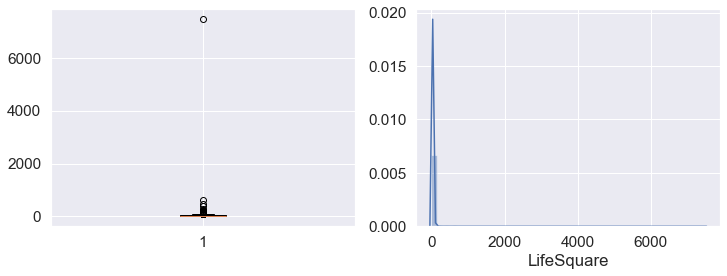

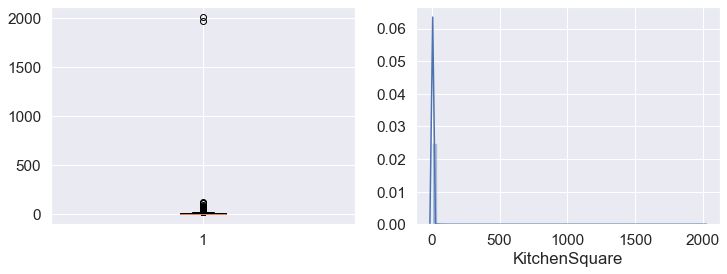

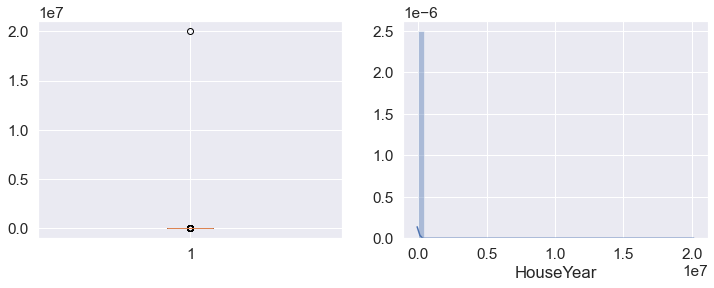

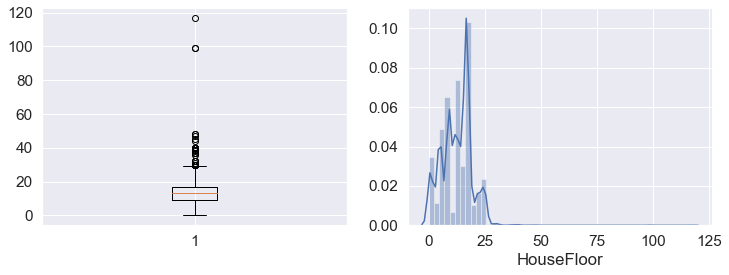

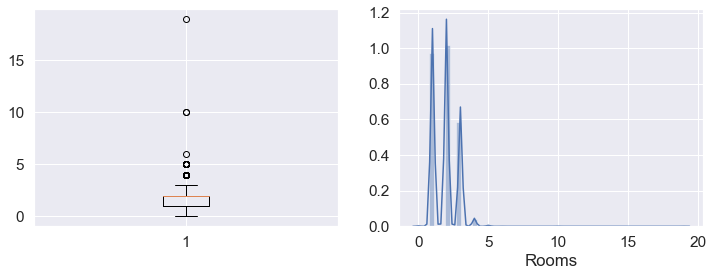

In [171]:
test_feature = ["Square", "LifeSquare", "KitchenSquare", "HouseYear", "HouseFloor", "Rooms"]

def show_feature_outliers(df, feature_name):
    plt.figure(figsize = (12,4))
    
    plt.subplot(1,2,1)
    plt.boxplot(df.loc[df[feature_name].notna(),feature_name])
    
    plt.subplot(1,2,2)
    sns.distplot(df.loc[df[feature_name].notna(),feature_name])

for feature in test_feature:
    show_feature_outliers(train_data, feature)

### 2.3 Анализ кореляции признаков и стоимости жилья

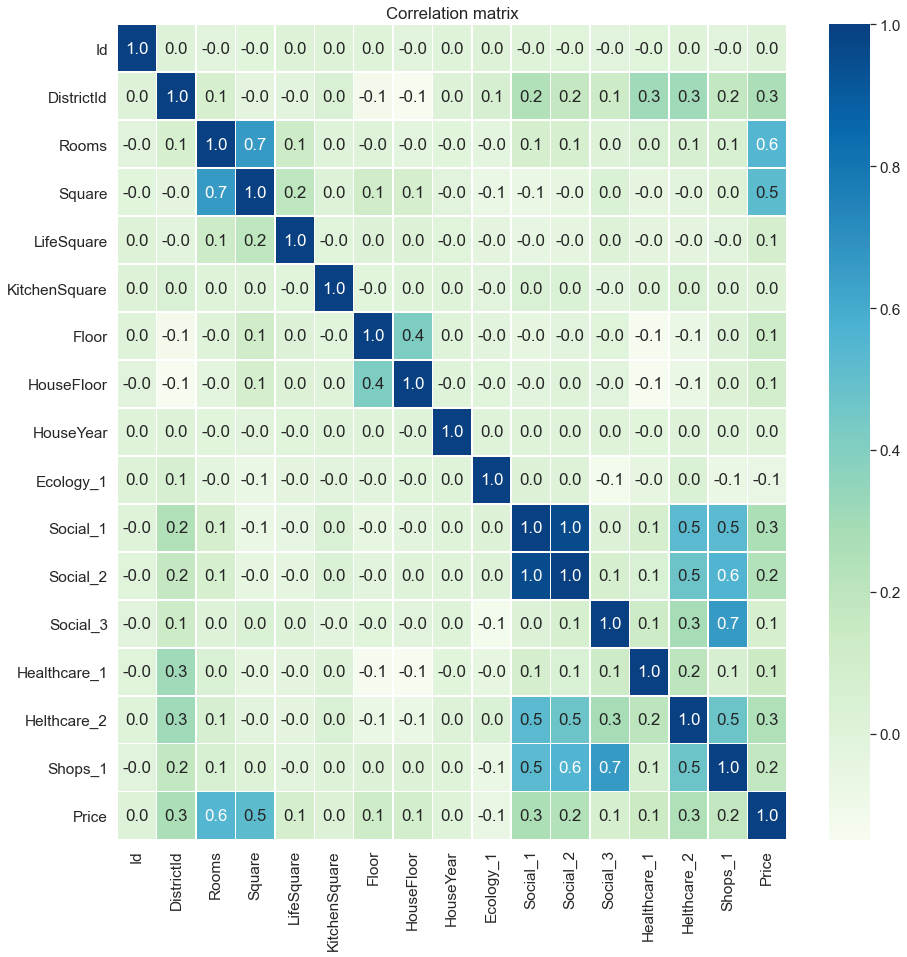

In [172]:
corr = train_data.corr()
plt.figure(figsize = (15, 15))
sns.set(font_scale=1.4)
sns.heatmap(train_data.corr(), annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show();

### 2.4 Анализ взаимного распределения площадных признаков и стоимости

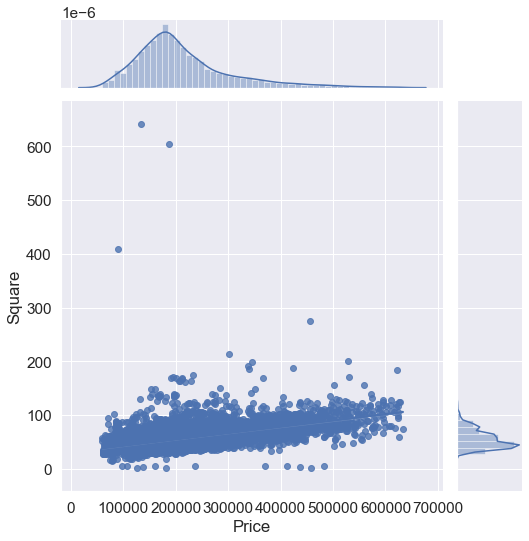

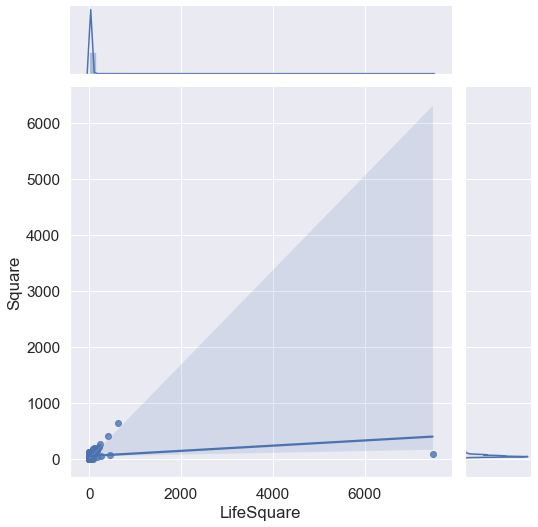

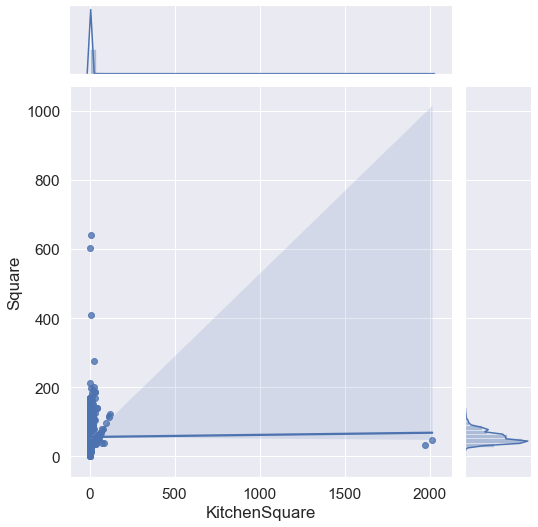

In [173]:
def show_joinplot(df, feature1, feature2):
    grid = sns.jointplot(df[feature1], df[feature2], kind='reg')
    grid.fig.set_figwidth(8)
    grid.fig.set_figheight(8)
    plt.show()
    
show_joinplot(train_data, "Price", "Square")
show_joinplot(train_data, "LifeSquare", "Square")
show_joinplot(train_data, "KitchenSquare", "Square")

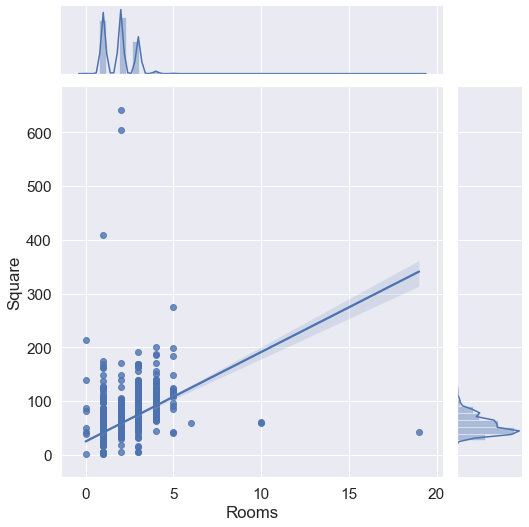

In [174]:
show_joinplot(train_data, "Rooms", "Square")

## 3 Обработка данных

In [175]:
class FeatureImputer:
    
    def __init__(self):
        
        self.medians = None
        self.dist_hc1_med = None
        self.dist_hc1_median = None
        self.current_year = None
        self.dist_date_med = None
        self.rooms_lsquare_mean = None
        self.rooms_square_mean = None
    
    def fit(self, X):

        #Вычислим медианы
        self.medians = X.median()
        
        #Вычислим медиану Healthcare_1 для районов, если не определено - заменяем медианой по районам
        self.dist_hc1_med = X.groupby(['DistrictId'])[['Healthcare_1']].median()
        self.dist_hc1_median = self.dist_hc1_med['Healthcare_1'].median()
        self.dist_hc1_med['Healthcare_1'] = self.dist_hc1_med['Healthcare_1'].fillna(self.dist_hc1_median)
        
        #Определяем текущий год и медиану года дома по району
        self.current_year = datetime.datetime.now().year
        self.dist_date_med = X.groupby(['DistrictId'])[['HouseYear']].median()
        
        #Определяем среднее отношение жилой площади к количеству комнат
        self.rooms_lsquare_mean = (X.loc[X['Rooms']!=0,'LifeSquare']/X.loc[X['Rooms']!=0,'Rooms']).mean()    
        
        #Определим среднюю площадь для 1,2,3-х комнатных квартир площадью меньше 150
        data_roms_square = X.loc[(X['Square'] < 150) & (X['Rooms'] > 0) & (X['Rooms'] < 4)]
        self.rooms_square_mean = data_roms_square.groupby(['Rooms'])[['Square']].mean()
        
    def transform(self, X):
        
        #Удаляем неинформативные признаки
        X = X.drop(['Shops_2', 'Ecology_2', 'Ecology_3'], axis = 1)
        
        #Если дата больше текущей - заменяем ее медианой по району
        for dist_ind in self.dist_date_med.index:
            X.loc[(X['HouseYear'] > self.current_year) & (X['DistrictId'] == dist_ind),'HouseYear'] = self.dist_date_med.loc[dist_ind,'HouseYear']
        
        #Если этаж равен 0, то заменяем его 1
        #Если этажность дома равна 0, то приравниваем этажность этажу плюс 6 (коэффициент определен по датасету)
        #Если этажность меньше этажа, то меняем их местами
        #Если этажность дома больше 50, то заменяем медианной этажностью
        X.loc[X['Floor'] == 0, "Floor"] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X.loc[X['HouseFloor'] == 0, 'Floor'] + 6
        ind = X.loc[X['HouseFloor'] < X['Floor']].index
        X.loc[ind, 'HouseFloor'], X.loc[ind, 'Floor'] = X.loc[ind, 'Floor'], X.loc[ind, 'HouseFloor']
        X.loc[X['HouseFloor'] > 50, 'HouseFloor'] = self.medians['HouseFloor']
        
        #Заполняем Healthcare_1 средними значениями по району
        #Если района не было в тренировочном датасете, заменяем Healthcare_1 вычисленной медианой
        for dist_ind in X['DistrictId'].unique():
            if dist_ind in self.dist_hc1_med.index:
                X.loc[(pd.isna(X['Healthcare_1'])) & (X['DistrictId'] == dist_ind),'Healthcare_1'] = self.dist_hc1_med.loc[dist_ind,'Healthcare_1']
            else:
                X.loc[(pd.isna(X['Healthcare_1'])) & (X['DistrictId'] == dist_ind),'Healthcare_1'] = self.dist_hc1_median
        
        #Если жилая площадь больше общей или неопределена, то определяем как разницу общей площади и площади кухни
        #минус 5 (коэффициент определен по датасету). Если жилая площадь отрицательная - меняем местами с площадью кухни
        ind = X.loc[(X["LifeSquare"] > X["Square"]) | (pd.isna(X["LifeSquare"]))].index
        X.loc[ind, "LifeSquare"] = X.loc[ind, "Square"] - X.loc[ind, "KitchenSquare"] - 5
        ind = X.loc[(X["LifeSquare"] < 0)].index
        X.loc[ind, "LifeSquare"], X.loc[ind, "KitchenSquare"] = X.loc[ind, "KitchenSquare"], X.loc[ind, "LifeSquare"]
        
        #Если количество комнат равно 0, то заменяем 1
        #Если количество комнат больше 5 или не определено, то расчитываем его относительно жилой площади
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        ind = X.loc[((X['Rooms'] > 5) | (pd.isna(X['Rooms'])))].index
        X.loc[ind, 'Rooms'] = round((X.loc[ind, 'LifeSquare'])/self.rooms_lsquare_mean)
        
        #Вычислим площадь квартиры относительно количества ее комнат
        for i in (1,2,3):
            X.loc[(X['Square'] > 150) & (X['Rooms'] == i),'Square'] = self.rooms_square_mean.loc[i,'Square']
            
        #Если площадь кухни больше чем разница общей и жилой площадей или меньше 0, то приравниваем к медиане площади кухни
        X.loc[((X["KitchenSquare"] > (X["Square"] - X["LifeSquare"])) | (X["KitchenSquare"] <= 0)), "KitchenSquare"] = self.medians['KitchenSquare']
        
        #Если жилая площадь оказалась меньше кухни - меняем местами
        ind = X.loc[(X["LifeSquare"] < X["KitchenSquare"])].index
        X.loc[ind, "LifeSquare"], X.loc[ind, "KitchenSquare"] = X.loc[ind, "KitchenSquare"], X.loc[ind, "LifeSquare"]
        
        #Если общая площадь оказалась меньше жилой - меняем местами
        ind = X.loc[(X["Square"] < X["LifeSquare"])].index
        X.loc[ind, 'LifeSquare'] = X.loc[ind, 'Square']
        
        #Если жилая площадь оказалась меньше 10, приравниваем к общей площади минус 10
        ind = X.loc[(X["LifeSquare"] < 10)].index
        X.loc[ind, 'LifeSquare'] = X.loc[ind, 'Square'] - 10
        
        #Если при площади квартиры больше 50 площадь кухни оказалась меньше 2 - заменяем медианой
        ind = X.loc[(X["KitchenSquare"] < 2) & (X["Square"] > 50)].index
        X.loc[ind, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        return X

In [176]:
class FeatureGenetator():
    
    def __init__(self):
        
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.current_year = None
        self.stat = None
        self.mean_price_per_square = None
        
    def fit(self, X, y=None):
        
        #Определим количества домов в районе, оставим только районы, где домов больше 50
        self.current_year = datetime.datetime.now().year
        district = X['DistrictId'].value_counts()
        district = district[district > 50]
        self.dist_popular = dict(district)
        
        #Вычислим среднюю стоимость квадратного метра по району
        X = X.join(y)
        X['Mean_price_per_sq'] = X['Price']/X['Square']
        self.dist_mean_price_per_square = X.groupby("DistrictId",as_index=False)[['Mean_price_per_sq']].mean().rename(columns={'Mean_price_per_sq':'Mean_price_per_square'})
        X = X.merge(self.dist_mean_price_per_square, on="DistrictId", how='left')
        self.mean_price_per_square = X['Mean_price_per_square'].mean()
        X.drop(['Mean_price_per_square', 'Mean_price_per_sq'], axis = 1)
        
        #Вычислим среднюю площадь по району и количеству комнат
        self.dist_rooms_mean_square_per_rooms = X.groupby(['DistrictId', 'Rooms'],as_index=False)[['Square']].mean().rename(columns={'Square':'Mean_square_per_rooms'})
        X = X.merge(self.dist_rooms_mean_square_per_rooms, on=["DistrictId", 'Rooms'], how='left')
        self.mean_squre_per_rooms = X['Mean_square_per_rooms'].mean()
        X.drop('Mean_square_per_rooms', axis = 1)
        
        #Вычислим среднюю стоимость для количества комнат
        self.rooms_ean_price_per_rooms = X.groupby('Rooms',as_index=False)[['Price']].mean().rename(columns={'Price':'Mean_price_per_rooms'})
        X = X.merge(self.rooms_ean_price_per_rooms, on='Rooms', how='left')
        self.mean_price_per_rooms = X['Mean_price_per_rooms'].mean()
        
    def transform(self, X):
        
        #Добавим признак популярности района
        X['DistrictId_count'] = X['DistrictId'].map(self.dist_popular)        
        X['DistrictId_count'].fillna(10, inplace=True)
        
        #Добавим признак возрастной категории дома
        X['Year_category'] = round((self.current_year - X['HouseYear'])/10)
        
        #Добавим признак - средняя стоимость квадратного метра в районе
        X = X.merge(self.dist_mean_price_per_square, on="DistrictId", how='left')
        X['Mean_price_per_square'] = X['Mean_price_per_square'].fillna(self.mean_price_per_square)
        
        #Добавим признак - средняя площадь для количества комнат в районе
        X = X.merge(self.dist_rooms_mean_square_per_rooms, on=["DistrictId", 'Rooms'], how='left')
        X['Mean_square_per_rooms'] = X['Mean_square_per_rooms'].fillna(self.mean_squre_per_rooms)
        
        #Добавим признак - средняя стоимость для количества комнат
        X = X.merge(self.rooms_ean_price_per_rooms, on='Rooms', how='left')
        X['Mean_price_per_rooms'] = X['Mean_price_per_rooms'].fillna(self.mean_price_per_rooms)
        
        return X

In [177]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)


features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)

## 4 Повторный анализ признаков

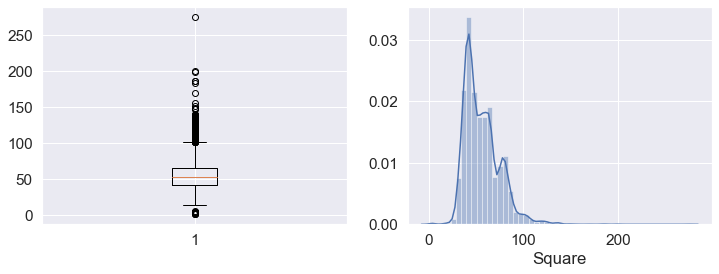

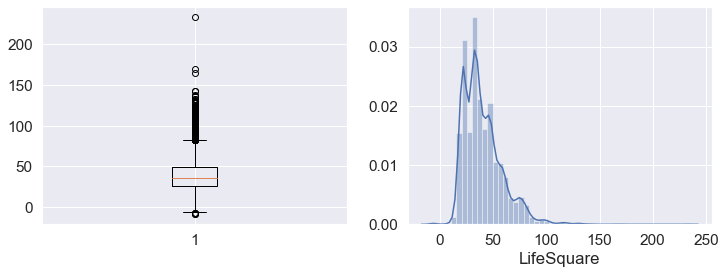

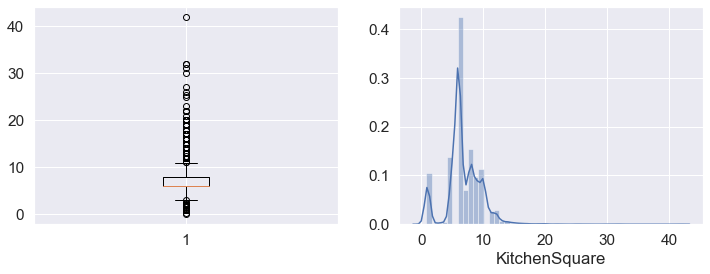

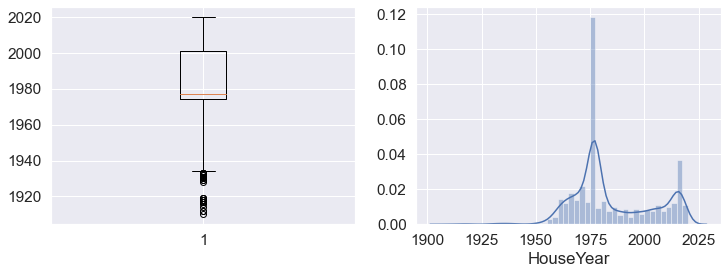

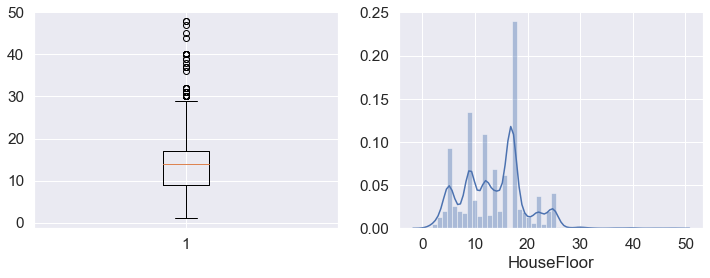

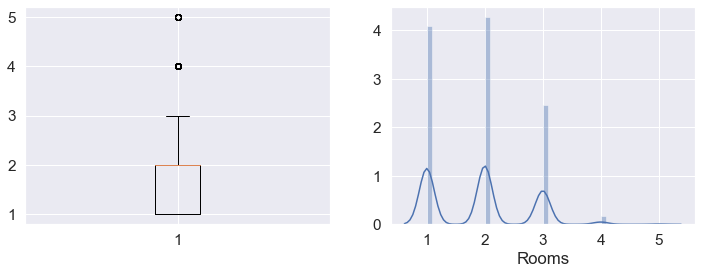

In [178]:
for feature in test_feature:
    show_feature_outliers(X, feature)

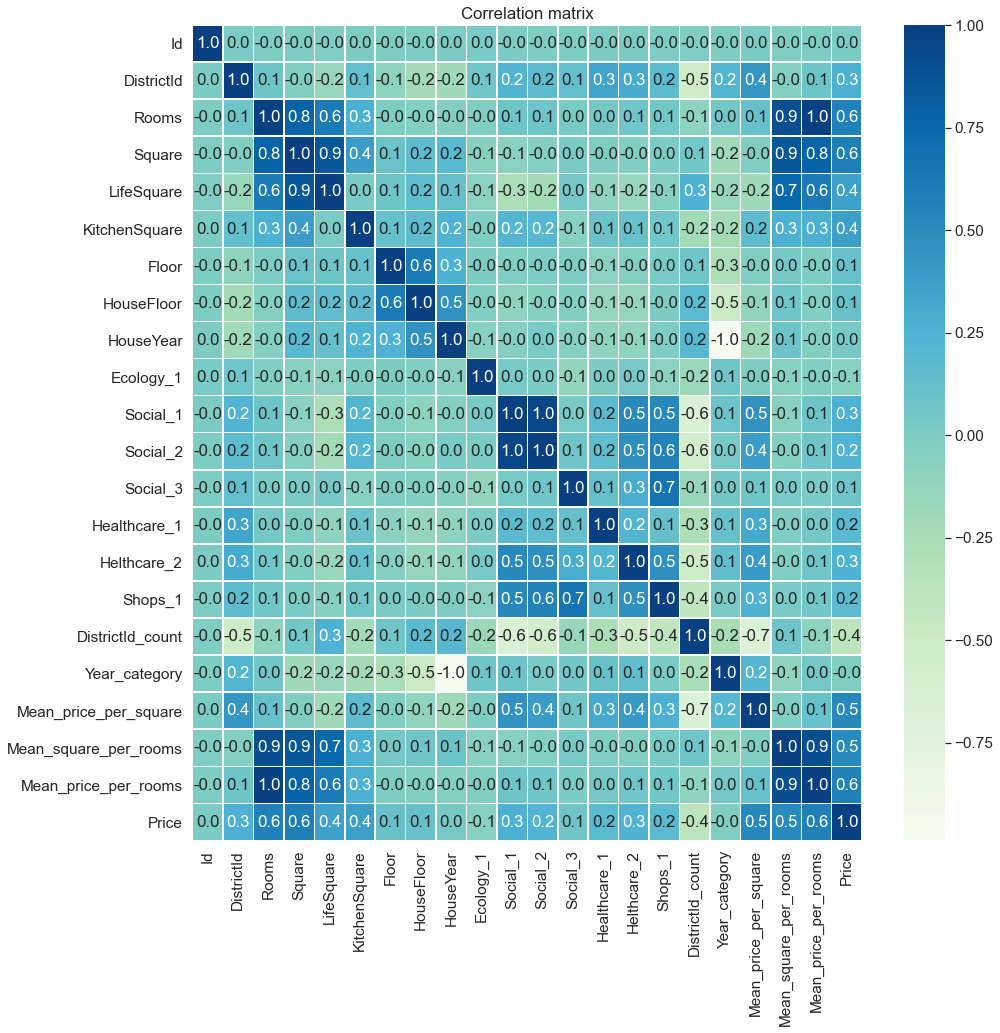

In [179]:
X = X.join(y)
corr = X.corr()
plt.figure(figsize = (15, 15))
sns.set(font_scale=1.4)
sns.heatmap(X.corr(), annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

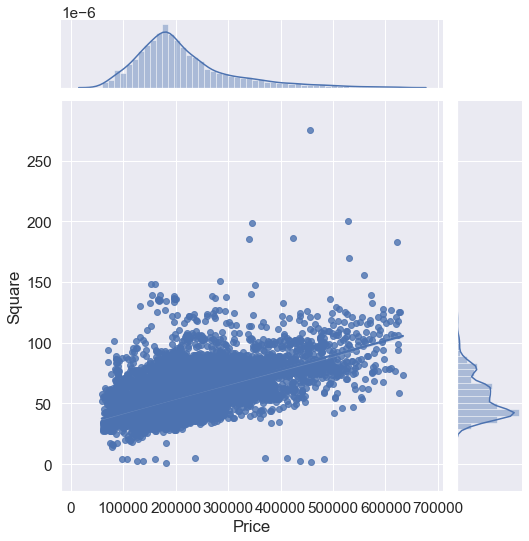

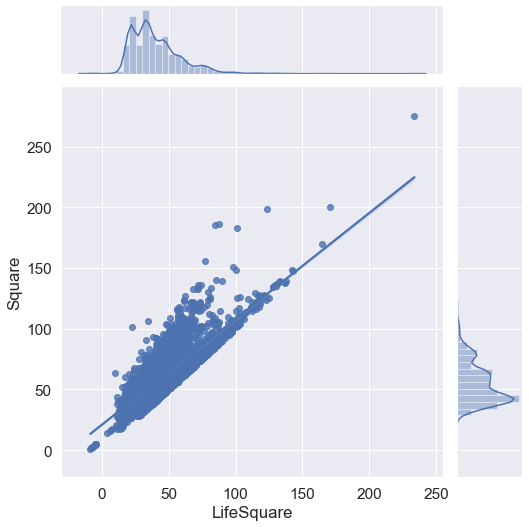

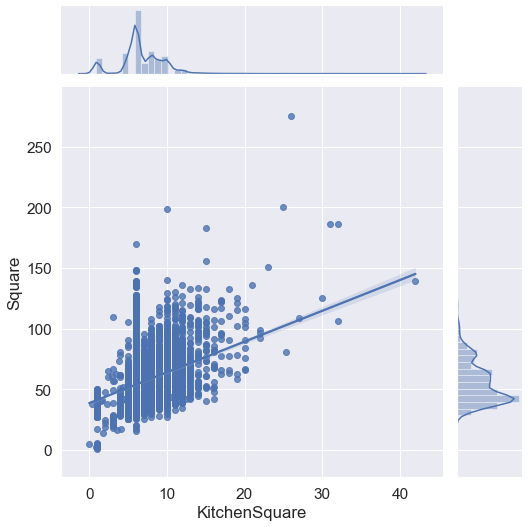

In [180]:
show_joinplot(X, "Price", "Square")
show_joinplot(X, "LifeSquare", "Square")
show_joinplot(X, "KitchenSquare", "Square")

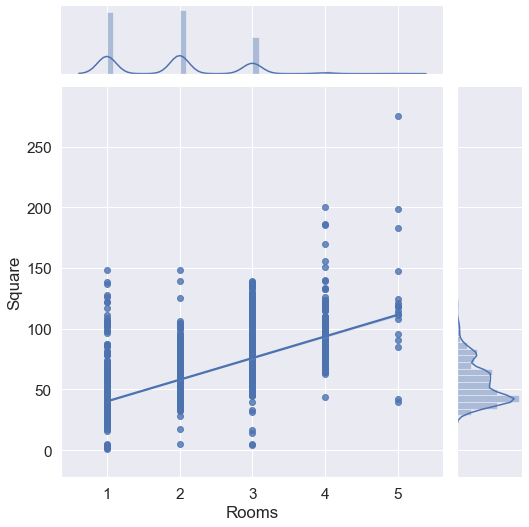

In [181]:
show_joinplot(X, "Rooms", "Square")

### Результаты:
#### 1) Устранены выбросы количественных признаков, заполнены NaN.
#### 2) Повышена корреляция признаков и стоимости жилья, добавлены новые признаки с высокой корреляцией.
#### 3) Очищены взаимные распределения площадных признаков и выравнена зависимость стоимости от них.